In [15]:
# Standard-Bibliotheken
import warnings
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn: Modellselektion und Validierung
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Scikit-learn: Feature-Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Scikit-learn: Modelle
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


# Scikit-learn: Metriken
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Scikit-learn: Pipeline
from sklearn.pipeline import Pipeline

# Warnungen ignorieren
warnings.simplefilter(action='ignore', category=FutureWarning)

### OPT 1: Laden Preprocess datei (Daten Test u. Train seperat)
- inkl. Aufteilung X_train, X_test, y_train, y_test, X_dev, y_dev

In [9]:
data_train = pd.read_csv("preprocessed/dataLemmaLowerStop_train.csv", on_bad_lines='skip', sep=';')
data_test = pd.read_csv("preprocessed/dataLemmaLowerStop_test.csv", on_bad_lines='skip', sep=';')

X_train = data_train['text']
y_train = data_train['group']
X_test =  data_test['text']
y_test = data_test['group']

X_test, X_dev, y_test, y_dev = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_dev.shape)
print(y_dev.shape)


(2624,)
(2624,)
(328,)
(328,)
(328,)
(328,)


### OPT 2: Laden Preprocess datei (Daten Test u. Train zsm.)
- inkl. Aufteilung X_train, X_test, y_train, y_test, X_dev, y_dev

In [ ]:
data = pd.read_csv("preprocessed/dataLemmaLowerStop.csv", on_bad_lines='skip', sep=';')
data = data.iloc[:,1:3]

X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['group'], test_size=0.2, random_state=42, stratify=data['group']
)

X_test, X_dev, y_test, y_dev = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_dev.shape)
print(y_dev.shape)

### OPT 3: Laden 20newgroups unprocessed
- inkl. Aufteilung X_train, X_test, y_train, y_test, X_dev, y_dev

In [ ]:
data = pd.read_csv("20 newsgroups/20newsgroups.csv", on_bad_lines='skip', sep=';')
data = data.dropna()
data = data.drop_duplicates()
data = data.iloc[:,1:3]

X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['group'], test_size=0.2, random_state=42, stratify=data['group']
)

X_test, X_dev, y_test, y_dev = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_dev.shape)
print(y_dev.shape)

### Tree Classifier ermittlung bester clf und tree Params (GridSearchCV)

Erklärung params:
- tfidf__max_df: Maximale Häufigkeit eines Begriffs in Dokumenten.
- tfidf__min_df: Minimale Häufigkeit eines Begriffs in Dokumenten.
- tfidf__max_features: Maximale Anzahl der zu extrahierenden Begriffe.
- tfidf__sublinear_tf eine Möglichkeit, die Bedeutung häufiger Begriffe in den Dokumenten zu dämpfen
- clf__max_depth: Maximale Tiefe des Entscheidungsbaums.
- clf__min_samples_split: Minimale Anzahl an Proben, um einen Knoten zu teilen.
- clf__criterion: Bewertungsfunktion für den Entscheidungsbaum. (entropy:feiner; gini:grober)
- clf__min_samples_leaf: Minimale Anzahl an Proben in einem Blatt des Entscheidungsbaums.

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.8,
        min_df=2,
        ngram_range=(1, 2), #TODO Anpassen für kontext => bisher (1,1) bestes Ergebnis
        stop_words='english',
        max_features=5000
    )),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'tfidf__max_df': [0.1, 0.2, 0.3],              # Unterschiedliche max_df-Werte testen
    'tfidf__min_df': [1, 2, 3, 5],                 # Tests mit mehr Flexibilität bei min_df
    'tfidf__max_features': [4000, 5000, 6000], # Variationen bei max_features
    'tfidf__sublinear_tf': [True, False],           # Sublineare Gewichtung vs. regulär
    'clf__min_samples_split': [2, 5, 10],           # Weitere Werte für min_samples_split
    'clf__min_samples_leaf': [1, 5, 10],            # Tests für min_samples_leaf
    'clf__max_depth': [100, 150, 200],        # Weitere Tests für Baumtiefe
    'clf__criterion': ['entropy'],          # Unterschiedliche Kriterien für Aufteilung
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                          # 5-fache Cross-Validation
    scoring='f1_macro',            # Optimierung auf F1-Score (macro)
    n_jobs=-1                      # Parallele Verarbeitung
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Beste Parameter:", best_params)

best_pipeline = grid_search.best_estimator_

y_dev_pred = best_pipeline.predict(X_dev)

print("F1-Score: ", f1_score(y_dev, y_dev_pred, average='macro'))
print("Precision: ", precision_score(y_dev, y_dev_pred, average='macro'))
print("Recall: ", recall_score(y_dev, y_dev_pred, average='macro'))
print(classification_report(y_dev, y_dev_pred))

### Tree Classifier ermittlung bester clf und tree Params (RandomizedSearchCV)

Erklärung params:
- tfidf__max_df: Maximale Häufigkeit eines Begriffs in Dokumenten.
- tfidf__min_df: Minimale Häufigkeit eines Begriffs in Dokumenten.
- tfidf__max_features: Maximale Anzahl der zu extrahierenden Begriffe.
- tfidf__sublinear_tf eine Möglichkeit, die Bedeutung häufiger Begriffe in den Dokumenten zu dämpfen
- clf__max_depth: Maximale Tiefe des Entscheidungsbaums.
- clf__min_samples_split: Minimale Anzahl an Proben, um einen Knoten zu teilen.
- clf__criterion: Bewertungsfunktion für den Entscheidungsbaum. (entropy:feiner; gini:grober)
- clf__min_samples_leaf: Minimale Anzahl an Proben in einem Blatt des Entscheidungsbaums.


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.8,
        min_df=2,
        ngram_range=(1, 2),
        stop_words='english',
        max_features=5000
    )),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_distributions = {
    'tfidf__max_df': [0.1, 0.2, 0.5, 0.7, 0.8, 0.9],
    'tfidf__min_df': [1, 2, 5, 10],
    'tfidf__max_features': [500, 5000, 10000, 15000, None],
    'tfidf__sublinear_tf': [True, False],
    'clf__max_depth': [None, 50, 100, 200],
    'clf__min_samples_split': [2, 5, 10],
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_leaf': [1, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=400,                    # Anzahl der zu testenden Kombinationen
    cv=5,                         # 5-fache Cross-Validation
    scoring='f1_macro',           # Optimierung auf F1-Score (macro)
    random_state=42,              # Zufälligkeit kontrollieren
    n_jobs=-1                     # Parallele Verarbeitung
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Beste Parameter:", best_params)

best_pipeline = random_search.best_estimator_

y_dev_pred = pipeline.predict(X_dev)

print("F1-Score: ", f1_score(y_dev, y_dev_pred, average='macro'))
print("Precision: ", precision_score(y_dev, y_dev_pred, average='macro'))
print("Recall: ", recall_score(y_dev, y_dev_pred, average='macro'))
print(classification_report(y_dev, y_dev_pred))

## Tree Classifier mit Vektor trainieren (ohne Search)
- Zum testen der momentan besten durch 

In [10]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        sublinear_tf=True,       # Logarithmische Gewichtung der TF
        min_df=2,                # Ignoriere Wörter, die weniger als 2-mal vorkommen
        max_features=5600,       # Maximal 5000 Features verwenden
        ngram_range=(1, 1),  # Anpassen für Kontext
        max_df=0.05,              # Ignoriere häufige Wörter, die mehr als 10% der Dokumente erscheinen
        stop_words='english'     # Stoppwörter entfernen
    )),
    ('clf', DecisionTreeClassifier(
        random_state=42,         # Zufälligkeit kontrollieren
        min_samples_split=2,     # Mindestens 2 Proben für eine Aufteilung
        min_samples_leaf=1,      # Mindestens 1 Probe im Blatt
        max_depth=200,           # Maximale Tiefe des Entscheidungsbaums
        criterion='gini'         # Gini-Kriterium für die Baumaufteilung
    ))
])

pipeline.fit(X_train, y_train)

y_dev_pred = pipeline.predict(X_dev)

print("F1-Score: ", f1_score(y_dev, y_dev_pred, average='macro'))
print("Precision: ", precision_score(y_dev, y_dev_pred, average='macro'))
print("Recall: ", recall_score(y_dev, y_dev_pred, average='macro'))
print(classification_report(y_dev, y_dev_pred))

F1-Score:  0.6960569199640945
Precision:  0.7128091328815769
Recall:  0.6923751686909582
              precision    recall  f1-score   support

           0       0.69      0.53      0.60        78
           1       0.84      0.80      0.82        95
           2       0.62      0.81      0.70        95
           3       0.69      0.63      0.66        60

    accuracy                           0.71       328
   macro avg       0.71      0.69      0.70       328
weighted avg       0.72      0.71      0.70       328



### Ermittlung endgültiger F1-Score (an ungesehenen Testdaten)

In [12]:
y_dev_pred = pipeline.predict(X_test)
print("F1-Score: ", f1_score(y_test, y_dev_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_dev_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_dev_pred, average='macro'))
print(classification_report(y_test, y_dev_pred))

F1-Score:  0.7171292513855766
Precision:  0.7268508327830361
Recall:  0.7153014802281411
              precision    recall  f1-score   support

           0       0.68      0.58      0.63        77
           1       0.88      0.78      0.83        95
           2       0.68      0.84      0.75        95
           3       0.67      0.66      0.66        61

    accuracy                           0.73       328
   macro avg       0.73      0.72      0.72       328
weighted avg       0.74      0.73      0.73       328



### Importancewerte nach Training mit TreeClassifier ausgeben

Wichtigste Features:
        Feature  Importance
3588      orbit    0.041607
2096     format    0.035055
626     atheist    0.030518
4556    shuttle    0.025961
1033  christian    0.023996
2417         hi    0.023444
2282   graphics    0.022445
191          3d    0.017801
1115      color    0.017194
2932     launch    0.016404


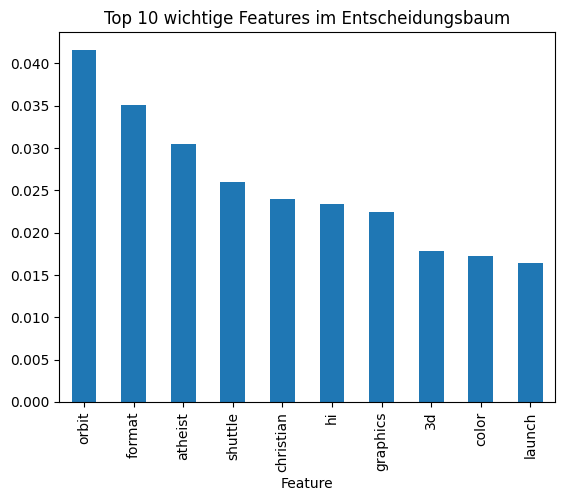

In [21]:
clf = pipeline.named_steps['clf']  
tfidf = pipeline.named_steps['tfidf']  

feature_names = tfidf.get_feature_names_out()

importances = clf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Wichtigste Features:")
print(importance_df.head(10))

importance_df.head(10).plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.title("Top 10 wichtige Features im Entscheidungsbaum")
plt.show()

### Optional: Speichern TFIDF-Matrix in csv


In [ ]:
tfidf = pipeline.named_steps['tfidf']

tfidf_matrix = tfidf.transform(X_train)

tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), 
    columns=tfidf.get_feature_names_out()
)

tfidf_df.to_csv("tfidf_matrix.csv", index=False, sep=';')
print("TF-IDF-Matrix wurde gespeichert.")

print(tfidf_df.head())


data_train['average_tfidf'] = tfidf_matrix.mean(axis=1)
average_per_class = data_train.groupby('group')['average_tfidf'].mean()
print("\nDurchschnittliche TF-IDF-Werte pro Klasse:\n", average_per_class)

### Optional: Histogramm Verteilung der TF-IDF-Werte plotten

In [ ]:
tfidf_values = tfidf_df.values.flatten()

plt.hist(tfidf_values, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Häufigkeitsverteilung der TF-IDF-Werte")
plt.xlabel("TF-IDF-Wert")
plt.ylabel("Häufigkeit")
plt.yscale('log')  
plt.show()

### Optional: Entscheidungsbaum ploten

NameError: name 'plt' is not defined